### KNN

En este notebook utilizaremos modelos de KNN para entrenar y clasificar el dataset con distintas configuraciones. Comenzaremos con la función de preprocesamiento que recrea lo realizado en la primera parte del TP, continuaremos con la función `preprocessing_significantes`, y a continuación exploraremos los resultados obtenidos al utilizar PCA y t-SNE para intentar mejorar lo obtenido.

In [1]:
# Modelo
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing
import preprocessing
import utils
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

# No supervisado
from sklearn.manifold import TSNE

Definimos los hiperparámetros que probaremos y sus valores posibles, para la validación cruzada.

In [2]:
params = { 'n_neighbors': range(10,300,5), 'weights': ('uniform', 'distance'), 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': range(1,3) }
model = KNeighborsClassifier()

### Preprocessing base

Comenzamos por entrenar un modelo de KNN bajo las mismas condiciones en las que realizamos el baseline de la primera parte del TP.

In [11]:
df_base = utils.get_data()

In [12]:
gscv_base = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [13]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_base.drop('tiene_alto_valor_adquisitivo',1), df_base['tiene_alto_valor_adquisitivo'], random_state=112)
X_train_base, X_test_base = preprocessing.preprocessing_base_parte_1(X_train_base, X_test_base)

In [14]:
%%time
gscv_base.fit(X_train_base, y_train_base)
score_base = roc_auc_score(y_test_base, gscv_base.predict_proba(X_test_base)[:,1])

Fitting 5 folds for each of 696 candidates, totalling 3480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

CPU times: user 24.6 s, sys: 2.39 s, total: 27 s
Wall time: 36min 37s


In [16]:
gscv_base.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}

In [17]:
score_base

0.8937630186206427

In [18]:
print(classification_report(y_test_base,gscv_base.predict(X_test_base)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6182
           1       0.72      0.58      0.65      1959

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.77      8141
weighted avg       0.84      0.85      0.84      8141



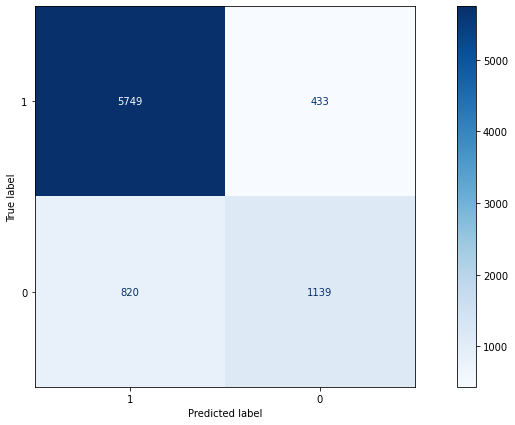

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv_base, X_test_base, y_test_base, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

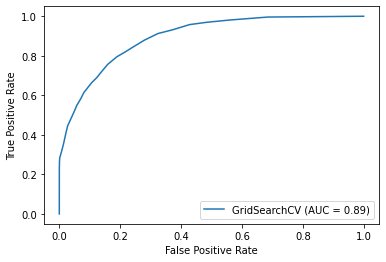

In [20]:
plot_roc_curve(gscv_base, X_test_base, y_test_base)

Notamos una performance decente, con un AUC-ROC de 0.89 y buenos valores de accuracy, precission y recall, particularmente para predecir muestras que no tienen un valor adquisitivo alto.

### Preprocessing Significantes

Repetimos el procedimiento anterior, con otro preprocesamiento.

In [3]:
df = utils.get_data()

In [4]:
params = { 'n_neighbors': range(10,300,5), 'weights': ('uniform', 'distance'), 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': range(1,3) }
model = KNeighborsClassifier()

In [5]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [6]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)
X_train, X_test = preprocessing.preprocessing_significantes(X_train, X_test, 0.9)

/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test[

In [ ]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 5 folds for each of 696 candidates, totalling 3480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 82.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 114.2min


In [21]:
gscv.best_params_

NameError: name 'gscv_sig' is not defined

In [17]:
score

0.8807848586082633

In [18]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6182
           1       0.69      0.54      0.61      1959

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141



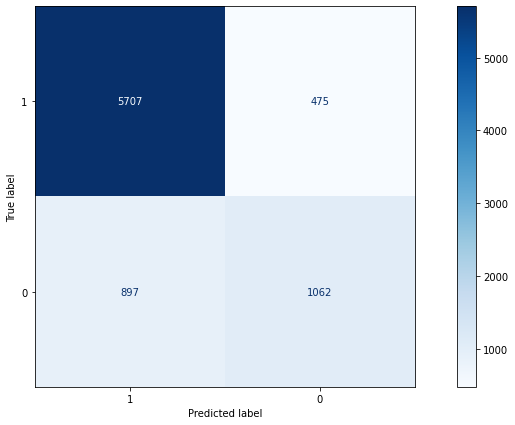

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

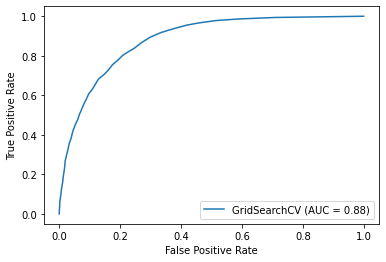

In [20]:
plot_roc_curve(gscv, X_test, y_test)

Vemos que los resultados, si bien no son pésimos, empeoraron respecto del primer caso. 

### Mejor separación con t-SNE

En línea con lo analizado en el notebook de análisis de preprocessings, entrenaremos un modelo de KNN con las variables seleccionadas al explorar el dataset usando t-SNE.

In [ ]:
df = utils.get_data()

In [ ]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

In [ ]:
X_train, X_test = preprocessing.preprocessing_mejor_separacion_tSNE(X_train, X_test)

In [ ]:
params = { 'n_neighbors': range(10,100,5), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose = 5)

In [15]:
%%time
gscv1.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

CPU times: user 4.6 s, sys: 415 ms, total: 5.01 s
Wall time: 4min 56s


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('ball_tree', 'kd_tree'),
                         'n_neighbors': range(10, 100, 5), 'p': range(1, 3),
                         'weights': ('uniform', 'distance')},
             scoring='roc_auc', verbose=10)

#### El mejor modelo:

In [16]:
print(gscv1.best_estimator_)
print(gscv1.best_params_)
print(gscv1.best_score_)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=95, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 95, 'p': 1, 'weights': 'uniform'}
0.8431078804911539


In [18]:
print(classification_report(y_test,gscv1.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      6182
           1       0.71      0.41      0.52      1959

    accuracy                           0.82      8141
   macro avg       0.77      0.68      0.70      8141
weighted avg       0.81      0.82      0.80      8141



In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

In [ ]:
plot_roc_curve(gscv, X_test, y_test)

### Selección de 4 variables a partir de un árbol

Continuando con los preprocessings analizados, pasamos a entrenar un modelo sobre las variables obtenidas usando un árbol:

* Rol familiar registrado casado
* Ganancia/Pérdida declarada en la bolsa argentina.
* Años estudiados.
* Edad

In [27]:
df = utils.get_data()

In [4]:
params = { 
    'n_neighbors': range(10,100,5), 
    'weights': ('uniform', 'distance'), 
    'algorithm': ['ball_tree', 'kd_tree', 'brute'], 
    'p': range(1,3) 
}

model = KNeighborsClassifier()

In [5]:
gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=4, verbose=5)

In [6]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)
X_train, X_test = preprocessing.preprocessing_4_mejores_variables_arbol

/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/nicolascontinanza/Desktop/FIUBA/Datos/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test[

In [ ]:
%%time
gscv.fit(X_train, y_train)
score = roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1])

Fitting 5 folds for each of 696 candidates, totalling 3480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 82.5min


In [21]:
gscv.best_params_

NameError: name 'gscv_sig' is not defined

In [17]:
score

0.8807848586082633

In [18]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6182
           1       0.69      0.54      0.61      1959

    accuracy                           0.83      8141
   macro avg       0.78      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141



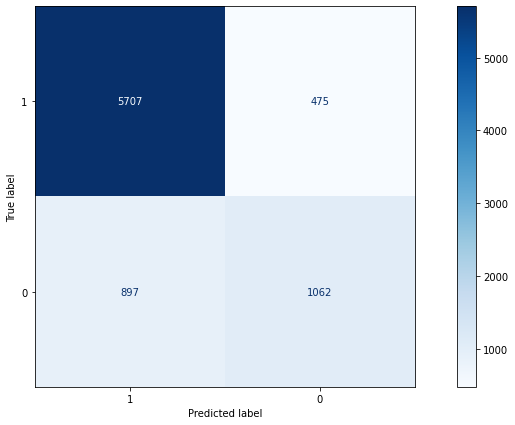

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(gscv, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

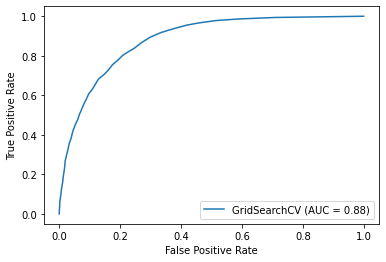

In [20]:
plot_roc_curve(gscv, X_test, y_test)

### PCA para explicar el 75% de la varianza

Para terminar, veamos qué se obtiene al preprocesar los datos usando PCA con un valor tal que se explique el 75% de la varianza.

### Mejor separación por TSNE

Continuaremos por buscar la mejor combinación de atributos de forma tal que generen un patrón observable con TSNE, para luego clasificar con KNN el dataset transformado.

Partiremos del dataset original, realizándole el mismo tratamiento que hicimos en la parte 1 del TP y seleccionando únicamente las variables continuas.

In [8]:
df = utils.get_data()

In [9]:
def dejar_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'horas_trabajo_registradas']].copy()

In [10]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

#### Análisis sobre las variables continuas

Estandarizamos el set de entrenamiento

In [11]:
scaler1 = StandardScaler()

X_train1 = pd.DataFrame(scaler1.fit_transform(dejar_variables_continuas(X_train)))
X_test1 = pd.DataFrame(scaler1.transform(dejar_variables_continuas(X_test)))

In [12]:
X_tsne = TSNE(learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_train1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.445s...
[t-SNE] Computed neighbors for 24420 samples in 1.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sam

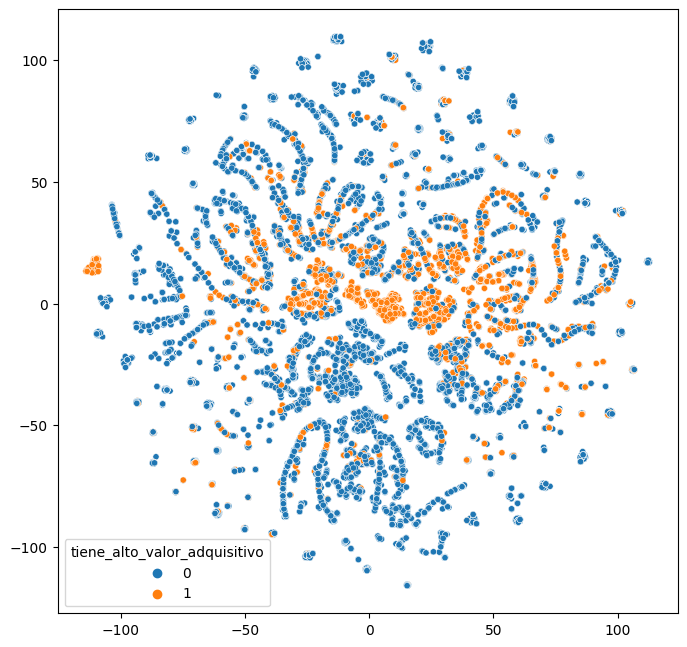

In [13]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=20
)

plt.show()

Podemos ver que la separación no es mala, habiendo regiones con una clara concentración de muestras con alto valor adquisitivo. Veamos que ocurre al entrenar un modelo de KNN. Esta vez, dejaremos que el clasificador elija el algoritmo para computar los vecinos más cercanos.

### Entrenando el primer modelo

In [14]:
params = { 'n_neighbors': range(10,100,5), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose = 10)

In [15]:
%%time
gscv1.fit(X_train1, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

CPU times: user 4.6 s, sys: 415 ms, total: 5.01 s
Wall time: 4min 56s


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('ball_tree', 'kd_tree'),
                         'n_neighbors': range(10, 100, 5), 'p': range(1, 3),
                         'weights': ('uniform', 'distance')},
             scoring='roc_auc', verbose=10)

### El mejor modelo:

In [16]:
print(gscv1.best_estimator_)
print(gscv1.best_params_)
print(gscv1.best_score_)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=95, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 95, 'p': 1, 'weights': 'uniform'}
0.8431078804911539


##### Observaciones

TBD

In [17]:
gscv1.cv_results_

{'mean_fit_time': array([0.537816  , 0.83897309, 0.57566829, 0.48085303, 0.58434143,
        0.500769  , 0.55896301, 0.50129404, 0.65957751, 0.71987095,
        0.74714041, 0.84503727, 0.61497016, 0.77945318, 0.96670303,
        0.75562878, 0.5581224 , 0.56851611, 0.6466836 , 0.67986193,
        0.61695795, 0.63308592, 0.62443233, 0.54686217, 0.5054698 ,
        0.57020688, 0.57547264, 0.59238896, 0.60628839, 0.51577735,
        0.55629873, 0.54820442, 0.51872053, 0.55194683, 0.58074727,
        0.55438185, 0.55295782, 0.53807359, 0.53266115, 0.5740324 ,
        0.53512821, 0.51797862, 0.51010857, 0.63242126, 0.51121707,
        0.524404  , 0.5350431 , 0.51977925, 0.60553951, 0.50576453,
        0.539852  , 0.54870744, 0.54097776, 0.54927964, 0.52372975,
        0.53476157, 0.56949401, 0.52453332, 0.67693763, 0.63927102,
        0.55719604, 0.57658801, 0.54835219, 0.52269754, 0.55647154,
        0.52202573, 0.62191825, 0.5157413 , 0.66561198, 0.56312366,
        0.56552916, 0.64324288,

In [18]:
print(classification_report(y_test,gscv1.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      6182
           1       0.71      0.41      0.52      1959

    accuracy                           0.82      8141
   macro avg       0.77      0.68      0.70      8141
weighted avg       0.81      0.82      0.80      8141



Obtenemos un accuracy aceptable, con un recall muy pobre para los 1s, por lo que consideramos que la selección de variables no fue buena. Veamos con otras combinaciones.

De forma similar a lo realizado con SVM, nos quedaremos con las siguientes variables:
 * Edad
 * Ganancia/Pérdida declarada en la bolsa argentina
 * Años estudiados

In [19]:
def dejar_mejores_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad']].copy()

In [20]:
scaler2 = StandardScaler()

X_train2 = pd.DataFrame(scaler2.fit_transform(dejar_mejores_variables_continuas(X_train)))
X_test2 = pd.DataFrame(scaler2.transform(dejar_mejores_variables_continuas(X_test)))

Veamos si TSNE nos muestra algo interesante:

In [21]:
X_tsne = TSNE(n_components=2, perplexity=200, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_train2)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.474s...
[t-SNE] Computed neighbors for 24420 samples in 3.871s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

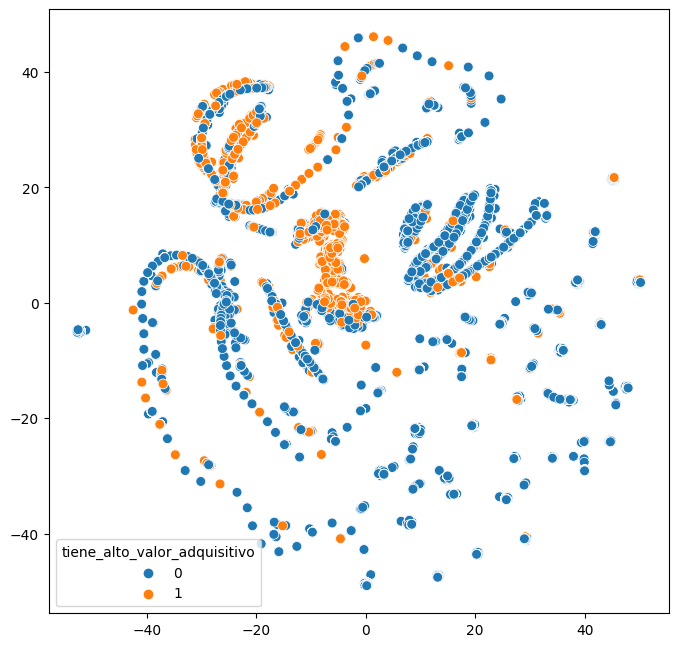

In [22]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=50
)

plt.show()

No parece haber ningún tipo de patrón visible, aunque hay algunas regiones con más concentración de 1s.

In [23]:
params = { 'n_neighbors': range(10,100,5), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv3 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose = 10)

In [24]:
%%time
gscv3.fit(X_train2, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

CPU times: user 4.14 s, sys: 376 ms, total: 4.52 s
Wall time: 3min 13s


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('ball_tree', 'kd_tree'),
                         'n_neighbors': range(10, 100, 5), 'p': range(1, 3),
                         'weights': ('uniform', 'distance')},
             scoring='roc_auc', verbose=10)

### El mejor modelo:

In [ ]:
print(gscv3.best_estimator_)
print(gscv3.best_params_)
print(gscv3.best_score_)

Vemos que esta vez el modelo es distinto, con una leve mejora en el score. 

In [ ]:
print(classification_report(y_test,gscv3.predict(X_test2)))

Con valores e interpretaciones similares a las anteriores.

### Veamos qué sucede si elegimos las primeras variables (no sólo continuas) que elije un árbol de decisión de altura 3. 

Repitiendo la selección realizada para el caso de SVM, nos quedaremos con las siguientes variables seleccionadas con un árbol de altura 3:

* Rol familiar registrado casado
* Ganancia/Pérdida declarada en la bolsa argentina.
* Años estudiados.
* Edad

In [27]:
def primeras_4_del_arbol(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'rol_familiar_registrado_casado']].copy()

In [15]:
scaler3 = MinMaxScalerScaler()
X_train3, X_test3 = pd.DataFrame(scaler3.fit_transform(preprocessing.preprocessing_4_mejores_variables_arbol(X_train, X_test)))


NameError: name 'MinMaxScalerScaler' is not defined

Nuevamente veamos qué nos dice TSNE

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_train3)

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=50
)

plt.show()

Nuevamente vemos que no hay un patrón distinguible, pero repetiremos el procedimiento anterior para comparar modelos y resultados obtenidos.

In [ ]:
params = { 'n_neighbors': range(10,100,5), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv4 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose = 10)

In [ ]:
%%time
gscv4.fit(X_train3, y_train)

In [ ]:
print(gscv4.best_estimator_)
print(gscv4.best_params_)
print(gscv4.best_score_)

In [ ]:
print(classification_report(y_test,gscv4.predict(X_test3)))

Contrariamente a nuestra expectativa inicial, obtuvimos un nuevo modelo con un score notablemente mejor, pero que sigue sin superar a los obtenidos anteriormente con otros preprocesamientos.

### Variables no continuas

Al igual que en el caso de SVM, nos quedaremos con las siguientes variables para continuar nuestro análisis:

* religion_budismo
* trabajo_entretenimiento
* rol_familiar_registrado_otro


In [35]:
# La función deja las continuas que resultaron significativas para los previos árboles, la variable de 
# rol_familiar_registrado_casado pues antes también había resultado importante junto a las continuas.
# Pero además suma las 3 variables arriba mencionadas.
def quedarse_las_importantes(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'rol_familiar_registrado_casado', 'religion_budismo', 
              'trabajo_entretenimiento', 'rol_familiar_registrado_otro']].copy()

In [44]:
scaler4 = StandardScaler()

X_train4, X_test4 = pd.DataFrame(scaler4.fit_transform(quedarse_las_importantes(X_train)))


In [45]:
params = { 'n_neighbors': range(10,100,5), 
          'weights': ('uniform', 'distance'),
          'algorithm': ('ball_tree', 'kd_tree'),
          'p': range(1,3) }

model = KNeighborsClassifier()

gscv6 = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, verbose = 10)

In [46]:
%%time
gscv6.fit(X_train4, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

CPU times: user 4.06 s, sys: 311 ms, total: 4.37 s
Wall time: 8min 27s


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('ball_tree', 'kd_tree'),
                         'n_neighbors': range(10, 100, 5), 'p': range(1, 3),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=10)

In [47]:
print(gscv6.best_estimator_)
print(gscv6.best_params_)
print(gscv6.best_score_)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=25, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
0.842956592956593


In [48]:
print(classification_report(y_test,gscv6.predict(X_test4)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6182
           1       0.71      0.57      0.63      1959

    accuracy                           0.84      8141
   macro avg       0.79      0.75      0.76      8141
weighted avg       0.83      0.84      0.83      8141



Vemos ahora que el score obtenido con este nuevo modelo se parece más a los iniciales, que a su vez se encontraban por debajo de lo obtenido en la primera parte del TP.

Para finalizar, realizaremos una predicción con KNN utilizando primero los datos proyectados con distintas configuraciones de PCA.

In [49]:
df = utils.feature_engineering(utils.get_data())

In [50]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

### PCA

Comenzamos por escalar los datos

In [51]:
pca = PCA()
scaler = StandardScaler()

X_train = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [52]:
np.cumsum(pca.explained_variance_ratio_)

array([0.05028142, 0.07969729, 0.10779481, 0.13430014, 0.15699954,
       0.17746556, 0.19582556, 0.2129726 , 0.22887798, 0.24426305,
       0.25844207, 0.27222755, 0.28593624, 0.29945955, 0.31243614,
       0.32528163, 0.33798268, 0.35053218, 0.36293177, 0.37527576,
       0.38747316, 0.39951856, 0.41150835, 0.42346723, 0.43533933,
       0.44717638, 0.45890297, 0.47052046, 0.48209827, 0.49356145,
       0.50501442, 0.51644734, 0.52785862, 0.53925853, 0.55065687,
       0.5620481 , 0.5734347 , 0.58482004, 0.59620227, 0.60758296,
       0.61896171, 0.63033817, 0.64171273, 0.65308647, 0.66445794,
       0.67582184, 0.6871816 , 0.69853735, 0.70988819, 0.72120965,
       0.73252656, 0.74382324, 0.75510742, 0.76635704, 0.77758777,
       0.78879597, 0.7999804 , 0.81111872, 0.82222788, 0.83329518,
       0.84429592, 0.85525797, 0.86604969, 0.87662993, 0.88718171,
       0.89755071, 0.90780461, 0.91781118, 0.92768501, 0.93732993,
       0.94668245, 0.95554511, 0.96406717, 0.97203258, 0.97952

Veamos qué configuraciones usar, según la varianza explicada

In [53]:
for i in np.linspace(0.70, 0.95, 6):
    n = np.argmax(np.cumsum(pca.explained_variance_ratio_) > round(i, 2))
    print("Cantidad necesaria para explicar " + str(round(i, 2)) + "\tes " + str(n))

Cantidad necesaria para explicar 0.7	es 48
Cantidad necesaria para explicar 0.75	es 52
Cantidad necesaria para explicar 0.8	es 57
Cantidad necesaria para explicar 0.85	es 61
Cantidad necesaria para explicar 0.9	es 66
Cantidad necesaria para explicar 0.95	es 71


### 70% de la varianza

Se alcanza con 48 variables de PCA.

In [91]:
pca = PCA(48)
scaler = StandardScaler()

X_train70 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test70 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

#### Veamos cómo se comportó la transformación en una dimensión menor, para ello usaremos t-SNE

In [92]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_train70)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.221s...
[t-SNE] Computed neighbors for 24420 samples in 50.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for s

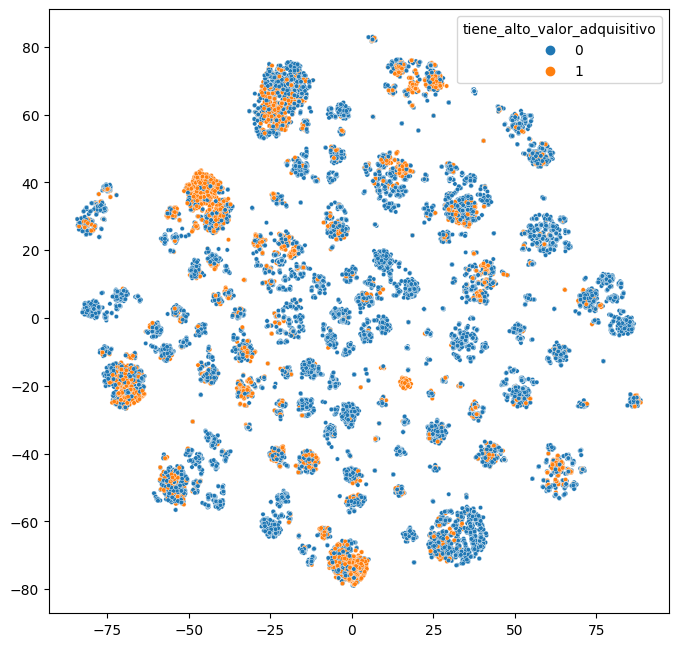

In [93]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

Viendo el resultado de TSNE parecen haber pequeños clusters, KNN podría funcionar correctamente. Veamos:

In [97]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,21),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv70 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [98]:
gscv70.fit(X_train70, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 115.0min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 21), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [99]:
print(gscv70.best_estimator_)
print(gscv70.best_params_)
print(gscv70.best_score_)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'}
0.8277641277641278


In [100]:
print(classification_report(y_test,gscv70.predict(X_test70)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6186
           1       0.71      0.52      0.60      1955

    accuracy                           0.83      8141
   macro avg       0.79      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141



Un accuracy decente para test. Veamos qué más se puede obtener aumentando la cantidad de componentes.

### 75% de la varianza

Se alcanza con 52 variables de PCA.

In [101]:
pca = PCA(52)
scaler = StandardScaler()

X_train75 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test75 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

Veamos si TSNE nos dice algo:

In [102]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_train75)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.209s...
[t-SNE] Computed neighbors for 24420 samples in 38.690s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for s

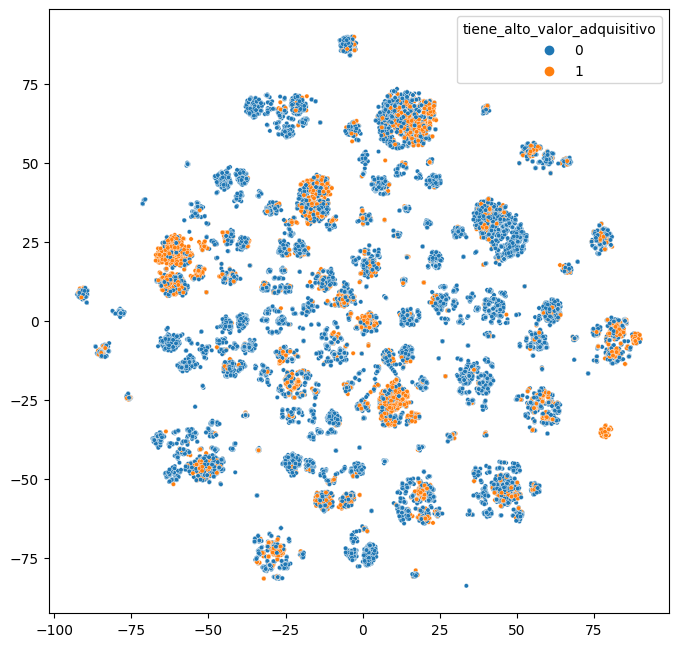

In [103]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

Nuevamente parece haber una buena separación, veamos qué hace KNN

In [104]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,21),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv75 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [105]:
gscv75.fit(X_train75, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 87.1min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 21), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [106]:
print(gscv75.best_estimator_)
print(gscv75.best_params_)
print(gscv75.best_score_)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'}
0.8287469287469287


In [107]:
print(classification_report(y_test,gscv75.predict(X_test75)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6186
           1       0.72      0.52      0.60      1955

    accuracy                           0.84      8141
   macro avg       0.79      0.73      0.75      8141
weighted avg       0.83      0.84      0.83      8141



Vemos que la predicción fue similar a la anteriormente obtenida.

### 80% de la varianza

In [108]:
pca = PCA(57)
scaler = StandardScaler()

X_train80 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test80 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [109]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_train80)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.218s...
[t-SNE] Computed neighbors for 24420 samples in 42.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for s

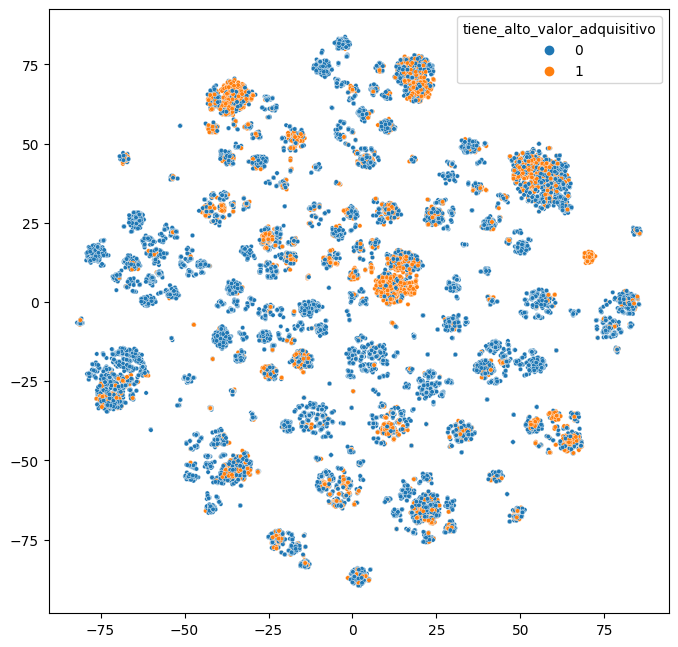

In [110]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=10
)

plt.show()

El resultado es similar a lo previamente observado, esperamos resultados similares.

In [111]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}
gscv80 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [112]:
gscv80.fit(X_train80, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 74.8min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 105.4min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 141.2min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 186.3min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 191.4min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [113]:
print(gscv80.best_estimator_)
print(gscv80.best_params_)
print(gscv80.best_score_)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=16, p=1)
{'algorithm': 'ball_tree', 'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}
0.825020475020475


In [114]:
print(classification_report(y_test,gscv80.predict(X_test80)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6186
           1       0.71      0.51      0.60      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



Como esperábamos, no hay mayores diferencias.

Veamos rápidamente qué sucede realizando búsquedas similares con las divisiones que faltan:

In [115]:
pca = PCA(61)
scaler = StandardScaler()

X_train85 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test85 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

pca = PCA(66)
scaler = StandardScaler()

X_train90 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test90 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

pca = PCA(71)
scaler = MinMaxScaler()

X_train95 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test95 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [116]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv85 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)
gscv90 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)
gscv95 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [117]:
gscv85.fit(X_train85, y_train)
gscv90.fit(X_train90, y_train)
gscv95.fit(X_train95, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 79.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 111.8min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 150.2min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 198.1min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 203.5min finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 83.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 117.3min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 158.5min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 209.5min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 215.2min finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 81.6min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 113.0min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 135.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 170.3min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 174.3min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [118]:
print("Modelo 85%")
print(gscv85.best_estimator_)
print(gscv85.best_params_)
print(gscv85.best_score_)

print("Modelo 90%")
print(gscv90.best_estimator_)
print(gscv90.best_params_)
print(gscv90.best_score_)

print("Modelo 95%")
print(gscv95.best_estimator_)
print(gscv95.best_params_)
print(gscv95.best_score_)

Modelo 85%
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'}
0.8257166257166257
Modelo 90%
KNeighborsClassifier(algorithm='kd_tree', n_neighbors=18, p=1)
{'algorithm': 'kd_tree', 'n_neighbors': 18, 'p': 1, 'weights': 'uniform'}
0.8254709254709255
Modelo 95%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=26)
{'algorithm': 'ball_tree', 'n_neighbors': 26, 'p': 2, 'weights': 'uniform'}
0.8328828828828829


In [119]:
print(classification_report(y_test,gscv85.predict(X_test85)))
print("\n\n")
print(classification_report(y_test,gscv90.predict(X_test90)))
print("\n\n")
print(classification_report(y_test,gscv95.predict(X_test95)))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6186
           1       0.70      0.51      0.59      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141




              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6186
           1       0.71      0.52      0.60      1955

    accuracy                           0.83      8141
   macro avg       0.78      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141




              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6186
           1       0.71      0.53      0.61      1955

    accuracy                           0.83      8141
   macro avg       0.79      0.73      0.75      8141
weighted avg       0.83      0.83      0.83      8141



Nada interesante para agregar.

Veamos qué ocurre en configuraciones que explican mucho menos varianza

In [120]:
for i in np.linspace(0.15, 0.50, 8):
    n = np.argmax(np.cumsum(pca.explained_variance_ratio_) > round(i, 2))
    print("Cantidad necesaria para explicar " + str(round(i, 2)) + "\tes " + str(n))

Cantidad necesaria para explicar 0.15	es 0
Cantidad necesaria para explicar 0.2	es 1
Cantidad necesaria para explicar 0.25	es 2
Cantidad necesaria para explicar 0.3	es 3
Cantidad necesaria para explicar 0.35	es 4
Cantidad necesaria para explicar 0.4	es 5
Cantidad necesaria para explicar 0.45	es 6
Cantidad necesaria para explicar 0.5	es 8


In [121]:
pca = PCA(2)
scaler = StandardScaler()

X_train25 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test25 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [122]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv25 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [123]:
gscv25.fit(X_train25, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  2.6min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [124]:
print("Modelo 25%")
print(gscv25.best_estimator_)
print(gscv25.best_params_)
print(gscv25.best_score_)

Modelo 25%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=38)
{'algorithm': 'ball_tree', 'n_neighbors': 38, 'p': 2, 'weights': 'uniform'}
0.7564291564291564


In [125]:
print(classification_report(y_test,gscv25.predict(X_test25)))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      6186
           1       0.27      0.02      0.03      1955

    accuracy                           0.75      8141
   macro avg       0.52      0.50      0.44      8141
weighted avg       0.64      0.75      0.66      8141



Ahora si, vemos una performance claramente peor, en todas las métricas que estamos analizando.

### 40% de la varianza explicada

In [126]:
pca = PCA(5)
scaler = StandardScaler()

X_train40 = pd.DataFrame(pca.fit_transform(scaler.fit_transform(X_train)))
X_test40 = pd.DataFrame(pca.transform(scaler.transform(X_test)))

In [127]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(1,41),
          'weights': ('uniform', 'distance'),
          'algorithm': ['ball_tree', 'kd_tree'],
          'p': [1, 2]}

gscv40 = GridSearchCV(knn, params, scoring='accuracy', n_jobs=-1, verbose=4)

In [128]:
gscv40.fit(X_train40, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed: 10.3min finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': range(1, 41), 'p': [1, 2],
                         'weights': ('uniform', 'distance')},
             scoring='accuracy', verbose=4)

In [129]:
print("Modelo 40%")
print(gscv40.best_estimator_)
print(gscv40.best_params_)
print(gscv40.best_score_)

Modelo 40%
KNeighborsClassifier(algorithm='ball_tree', n_neighbors=40)
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}
0.7762489762489763


In [130]:
print(classification_report(y_test,gscv40.predict(X_test40)))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      6186
           1       0.22      0.01      0.02      1955

    accuracy                           0.75      8141
   macro avg       0.49      0.50      0.44      8141
weighted avg       0.63      0.75      0.66      8141



No hay grandes cambios para comentar respecto de el caso con dos componentes.

TODO: conclusión final